In [1]:
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
from datasets import load_dataset

/home/saracandussio/.conda/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
base = pd.read_csv('/home/saracandussio/tesi-risultati/results/baseline-gemma-2-2b-it-hotpotqa.csv')
# bart = pd.read_csv('/home/saracandussio/tesi-risultati/results/bart-gemma-2-2b-it-hotpotqa.csv')
# roberta = pd.read_csv('/home/saracandussio/tesi-risultati/results/roberta-gemma-2-2b-it-hotpotqa.csv')
# nocont = pd.read_csv('/home/saracandussio/tesi-risultati/results/nocontext-gemma-2-2b-it-hotpotqa.csv')
cot = pd.read_csv('/home/saracandussio/tesi-risultati/results/cot-gemma-2-2b-it-hotpotqa.csv')
purecot = pd.read_csv('/home/saracandussio/tesi-risultati/results/pure-cot-gemma-2-2b-it-hotpotqa.csv')

In [6]:
def clean_text_final(text):
    text = re.sub(r'[^\w\s.,!?\'"\-:;()]+', '', text)  # Rimuove i caratteri speciali
    text = re.sub(r"['\"-]", '', text)  # Rimuove apostrofi, virgolette e trattini
    text = text.lower()  # Converte in minuscolo
    return text

In [9]:
base['correct'] = base['correct'].apply(clean_text_final)

base['thesis'] = base['thesis'].apply(clean_text_final)
base['synthesis'] = base['synthesis'].apply(clean_text_final)
base['oracle'] = base['oracle'].apply(clean_text_final)

# bart['synthesis'] = bart['synthesis'].apply(clean_text_final)
# roberta['synthesis'] = roberta['synthesis'].apply(clean_text_final)
cot['synthesis'] = cot['synthesis'].apply(clean_text_final)
# purecot['answer'] = purecot['answer'].apply(clean_text_final)

# nocont['thesis'] = nocont['thesis'].apply(clean_text_final)
# nocont['synthesis'] = nocont['synthesis'].apply(clean_text_final)

# TL;DR

|which model|baseline - thesis|baseline - synthesis|bart - synthesis|roberta - synthesis|oracle - synthesis| nocontext - thesis | nocontext - synthesis | CoT as antithesis |
|:---:|:---:|:---:|:---:|:---:|:---:| :---:|:---:| :---:| 
| phi-medium | 50.00% | 75.28% | 79.26% | 78.69% | 83.24% | 48.01% | 80.97% | 78.69% |

# Graphical comparison of success rates

In [10]:
def evaluation(correct_answer, candidate):
    matches = 0
    total = len(correct_answer)

    for i in range(total):
        
        if correct_answer[i] == candidate[i]:
            matches += 1

    return round(matches/total*100, 2)

In [12]:
print("Portion of correct thesis answers: {} %".format(evaluation(base['correct'], base['thesis'])))
print("Portion of correct baseline synthesis answers: {} %".format(evaluation(base['correct'], base['synthesis'])))
print("Portion of correct oracle synthesis answers: {} %".format(evaluation(base['correct'], base['oracle'])))
# print("Portion of correct BART synthesis answers: {} %".format(evaluation(bart['correct'], bart['synthesis'])))
# print("Portion of correct RoBERTa synthesis answers: {} %".format(evaluation(roberta['correct'], roberta['synthesis'])))
print("Portion of correct CoT synthesis answers: {} %".format(evaluation(base['correct'], cot['synthesis'])))
# print("Portion of correct CoT answers: {} %".format(evaluation(base['correct'], purecot['answer'])))
print('##############################################################')
# print("Portion of correct no context thesis answers: {} %".format(evaluation(nocont['correct'], nocont['thesis'])))
# print("Portion of correct no context synthesis answers: {} %".format(evaluation(nocont['correct'], nocont['synthesis'])))

Portion of correct thesis answers: 52.84 %
Portion of correct baseline synthesis answers: 57.67 %
Portion of correct oracle synthesis answers: 55.11 %
Portion of correct CoT synthesis answers: 58.52 %
##############################################################


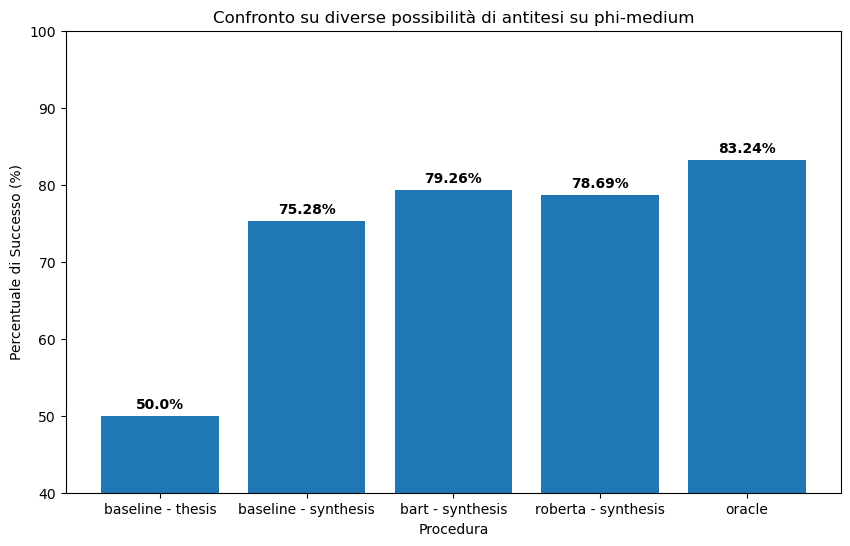

In [18]:
# Definire le procedure e le rispettive percentuali di successo
procedures = ['baseline - thesis', 'baseline - synthesis', 'bart - synthesis', 'roberta - synthesis', 'oracle']
success_rates = [evaluation(base['correct'], base['thesis']), evaluation(base['correct'], base['synthesis']), 
                 evaluation(base['correct'], bart['synthesis']), evaluation(base['correct'], roberta['synthesis']),
                 evaluation(base['correct'], base['goat'])]

# Creare il barplot
plt.figure(figsize=(10, 6))
plt.bar(procedures, success_rates)

# Aggiungere etichette e titolo
plt.xlabel('Procedura')
plt.ylabel('Percentuale di Successo (%)')
plt.title('Confronto su diverse possibilità di antitesi su phi-medium')
plt.ylim(0, 100)  # Impostare il limite dell'asse y da 0 a 100

# Mostrare il valore di ciascun bar
for i, v in enumerate(success_rates):
    plt.text(i, v + 1, str(v) + '%', ha='center', fontweight='bold')

plt.ylim(40, )
# Mostrare il grafico
plt.show()


# Impact of the best suggestion

But what about passing to the pipeline the correct answer as antithesis and trying to see the absorbing abilities of the pipeline? Which is the improvement? 
This is done in the column `goat` of the `base` file.

*(This is an important test since the previous result could suggest that the method could be indifferent to the suggestion, and this is not the case)*

In [70]:
goat_answers = base['goat']

print("Portion of correct GOAT suggestions: {} %".format(evaluation(correct_answers, goat_answers)))

Portion of correct GOAT suggestions: 83.24 %


Thus the correct suggestion has a positive on the prediction abilites of the model, even if it is NOT verbose: 

In [71]:
mean_tokens_goat = base['goat_antithesis'].apply(len).mean()
print(mean_tokens_goat) # not the most succinct but still

88.08522727272727


Of course, the portion of correct suggestions given by the antithesis in this scenario is 100%, thus it is clear that this pipeline does not faithfully blindly follows the suggestions. 
On the other hand, this intrinsic skepticism helps to check on the context and elaborate a new, synthetic answer. This means that in scenario in which the context is deceiving (or contains numbers/dates/difficult logical links to perform) even the perfect suggestion fails to convince the LLM on which is the correct option. 

It has not been performed an ablation study on the impacts of different "perfect suggestions" beyond the standard (i.e. `"the correct option is " + correct_answer + " since the other options are not mentioned in the context"`), since a concrete reference on the source documents would imply hand-crafted suggestions. 